In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load daily close data for some ETFs
df = pd.read_csv('ETF_prices.csv',index_col=0,parse_dates=True)
print('Loaded ', df.columns)

# resample to weekly frequency
weekly_prices = df.resample('W').ffill()

# compute compounded returns
weekly_returns = (weekly_prices).pct_change().dropna()

# compute the vol of SPY to create a risk driver series (toy example)
spy_vol = weekly_returns.SPY.ewm(span=52).std().ffill().fillna(0)

# store the returns shape
T, N = weekly_returns.shape

# inputs/parameters
ANNUALIZATION_FACTOR = 52
HALF_LIFE = ANNUALIZATION_FACTOR*10 # 10 years

Loaded  Index(['DBC', 'GLD', 'SPY', 'TLT'], dtype='object')


Effective number of scenarios of probabilities with uniform dist: 1006.0000000000003
Effective number of scenarios of probabilities via exp decay: 878.1857281784878
Effective number of scenarios of probabilities via gaussian kernel: 220.52113967772186


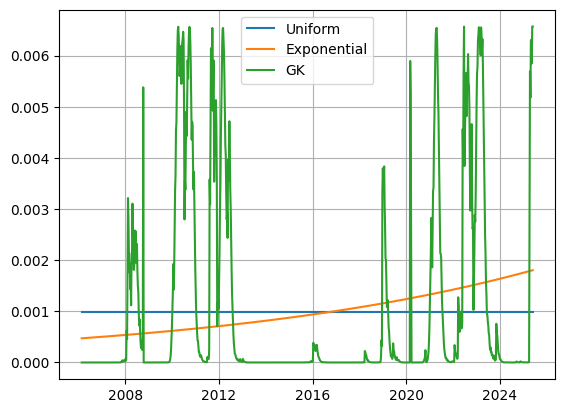

In [2]:
from pyvallocation import probabilities

# generate uniform probabilities
p_uniform = probabilities.generate_uniform_probabilities(T)
print('Effective number of scenarios of probabilities with uniform dist:', probabilities.compute_effective_number_scenarios(p_uniform))

# generate exponential decay probabilities
p_exp = probabilities.generate_exp_decay_probabilities(T,HALF_LIFE)
print('Effective number of scenarios of probabilities via exp decay:', probabilities.compute_effective_number_scenarios(p_exp))

# generate state conditioning probabilities via gaussian kernel
p_gk = probabilities.generate_gaussian_kernel_probabilities(spy_vol)
print('Effective number of scenarios of probabilities via gaussian kernel:', probabilities.compute_effective_number_scenarios(p_gk))

# visualize them
plt.plot(pd.Series(p_uniform,index=weekly_returns.index), label='Uniform')
plt.plot(pd.Series(p_exp,index=weekly_returns.index), label='Exponential')
plt.plot(pd.Series(p_gk,index=weekly_returns.index), label='GK')
plt.legend();plt.grid();plt.show()

In [3]:
from pyvallocation import moments

mu_uniform, cov_uniform = moments.estimate_sample_moments(weekly_returns,p_uniform)
mu_exp, cov_exp = moments.estimate_sample_moments(weekly_returns,p_exp)
mu_gk, cov_gk = moments.estimate_sample_moments(weekly_returns, p_gk)

mu_uniform_jorion = moments.shrink_mean_jorion(mu_uniform,cov_uniform,T)
print('Original mean from uniform prob:\n', mu_uniform*ANNUALIZATION_FACTOR)
print('Jorion-shirnked mean from uniform prob:\n', mu_uniform_jorion*ANNUALIZATION_FACTOR,'\n---')

print('Mean from exponential probabilities:\n',mu_exp*ANNUALIZATION_FACTOR)
print('Jorion-shirnked mean from exponential prob:\n', moments.shrink_mean_jorion(mu_exp,cov_exp,T)*ANNUALIZATION_FACTOR,'\n---')

print('Mean from state conditioning:\n',mu_gk*ANNUALIZATION_FACTOR)
print('Jorion-shirnked mean from state conditioning:\n', moments.shrink_mean_jorion(mu_gk,cov_gk,T)*ANNUALIZATION_FACTOR,'\n---')

cov_uniform_lw_cc = moments.shrink_covariance_ledoit_wolf(weekly_returns,cov_uniform,target='constant_correlation')
cov_uniform_lw_id = moments.shrink_covariance_ledoit_wolf(weekly_returns,cov_uniform,target='identity')

Original mean from uniform prob:
 DBC    0.024524
GLD    0.104242
SPY    0.113997
TLT    0.037689
Name: mu, dtype: float64
Jorion-shirnked mean from uniform prob:
 DBC    0.039253
GLD    0.086396
SPY    0.092165
TLT    0.047038
Name: mu, dtype: float64 
---
Mean from exponential probabilities:
 DBC    0.030864
GLD    0.109510
SPY    0.126099
TLT    0.017656
Name: mu, dtype: float64
Jorion-shirnked mean from exponential prob:
 DBC    0.039221
GLD    0.091669
SPY    0.102732
TLT    0.030414
Name: mu, dtype: float64 
---
Mean from state conditioning:
 DBC   -0.013594
GLD    0.109575
SPY    0.083216
TLT    0.054685
Name: mu, dtype: float64
Jorion-shirnked mean from state conditioning:
 DBC    0.013998
GLD    0.090472
SPY    0.074106
TLT    0.056392
Name: mu, dtype: float64 
---
